By William Gerle and Alfred Kjeller

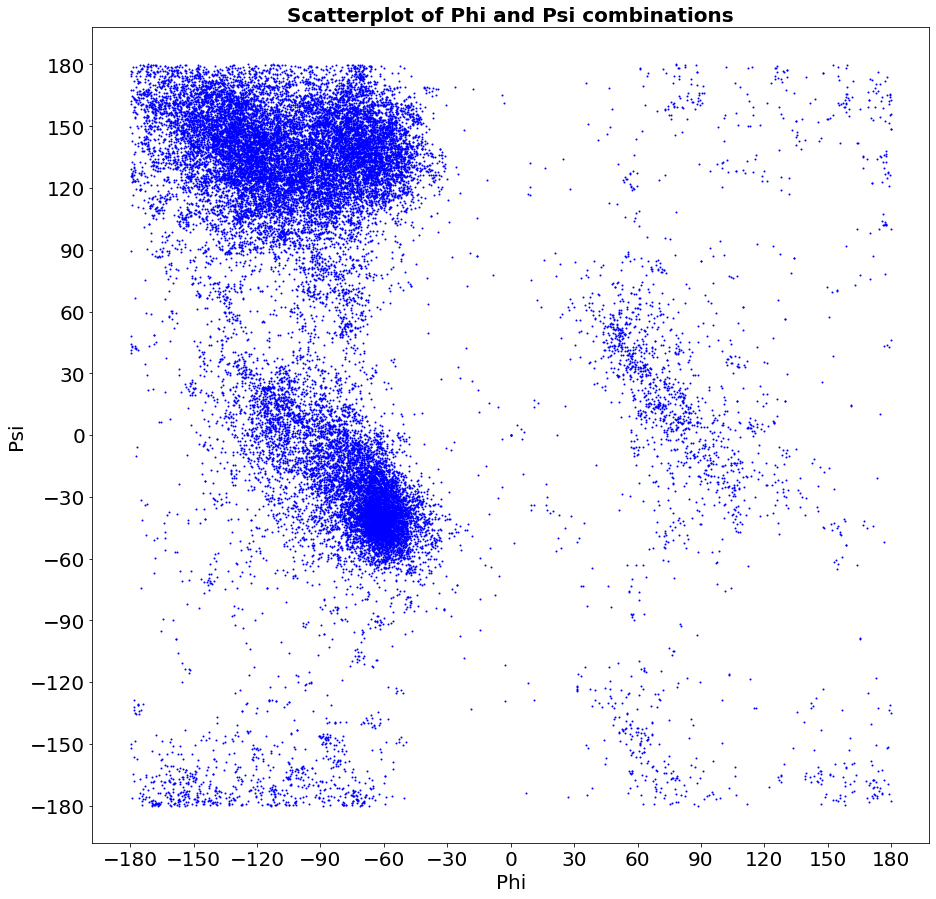

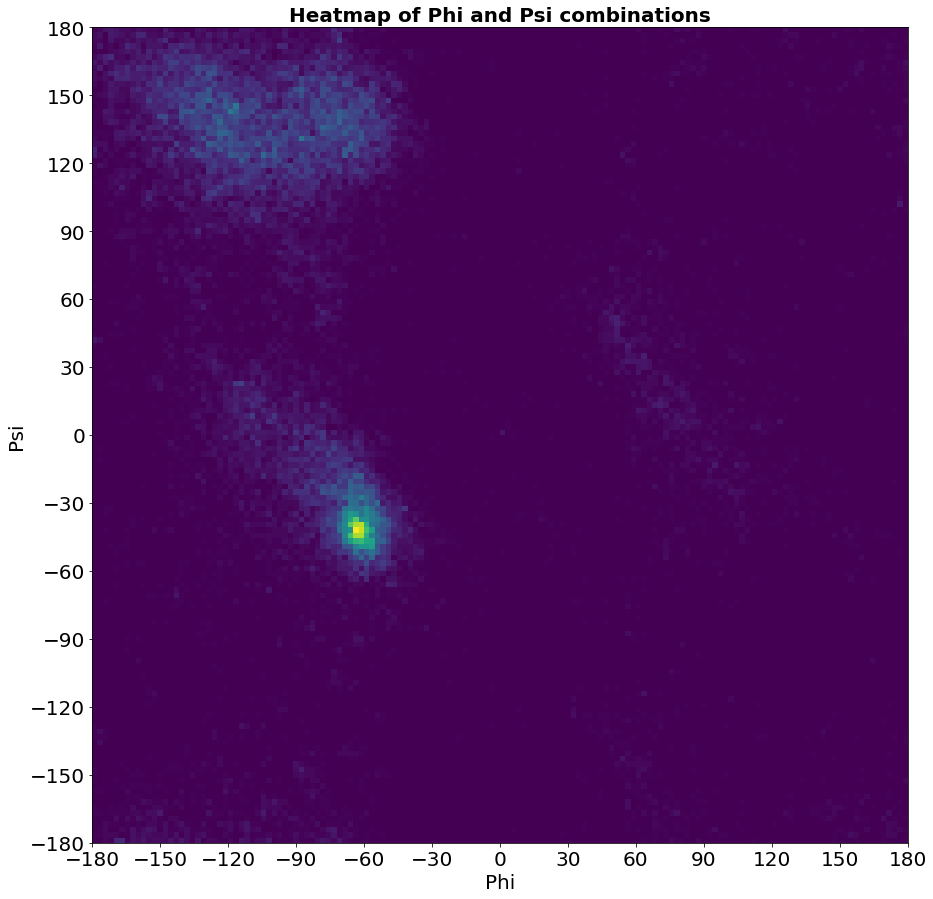

In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from itertools import cycle

#Load data
d = pd.read_csv('data_all.csv')
d.columns = d.columns.str.replace(' ', '')
x = d.phi
y = d.psi
X = list(zip(x, y))

#Scatter plot
plt.rcParams["figure.figsize"] = (15,15)
plt.scatter(x,y, s=1, c='b')
plt.title("Scatterplot of Phi and Psi combinations", fontsize=20, fontweight='bold')
plt.ylabel("Psi", fontsize=20)
plt.xlabel("Phi", fontsize=20)
plt.xticks(np.arange(-180, 210, step=30))
plt.yticks(np.arange(-180, 210, step=30))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

#Heatmap
heatmap, xedges, yedges = np.histogram2d(x, y, bins=150, range=[[-180, 180], [-180, 180]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.title("Heatmap of Phi and Psi combinations", fontsize=20, fontweight='bold')
plt.ylabel("Psi", fontsize=20)
plt.xlabel("Phi", fontsize=20)
plt.xticks(np.arange(-180, 210, step=30))
plt.yticks(np.arange(-180, 210, step=30))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

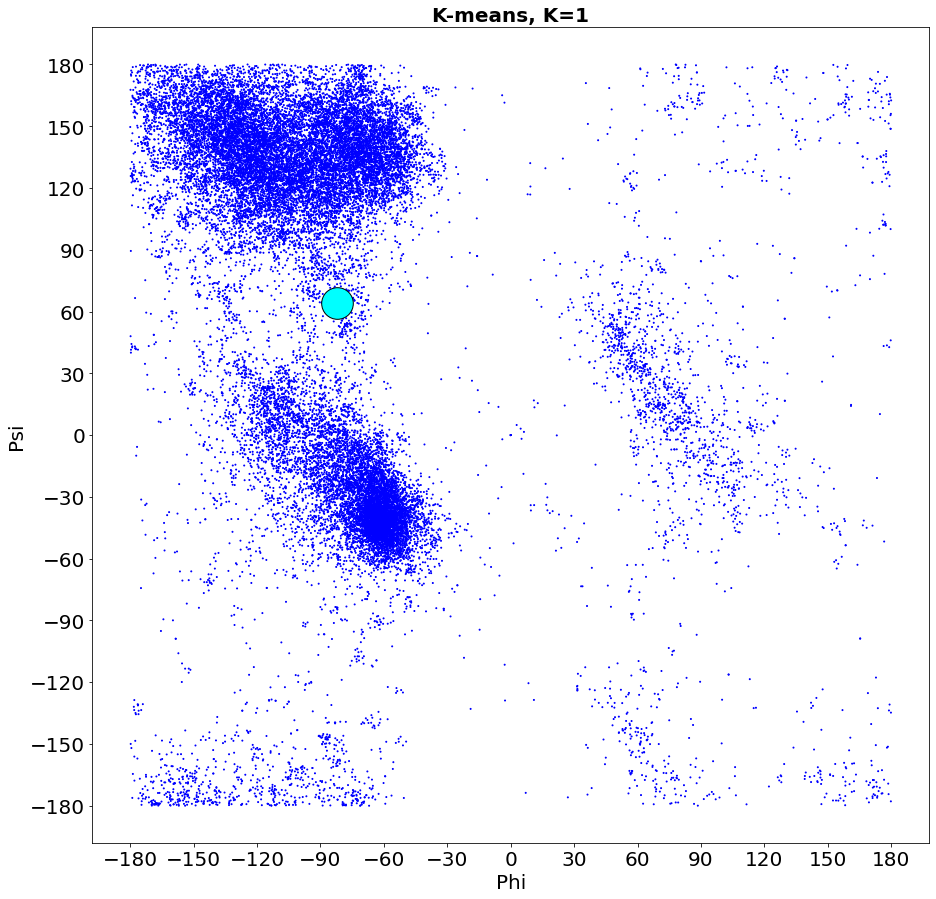

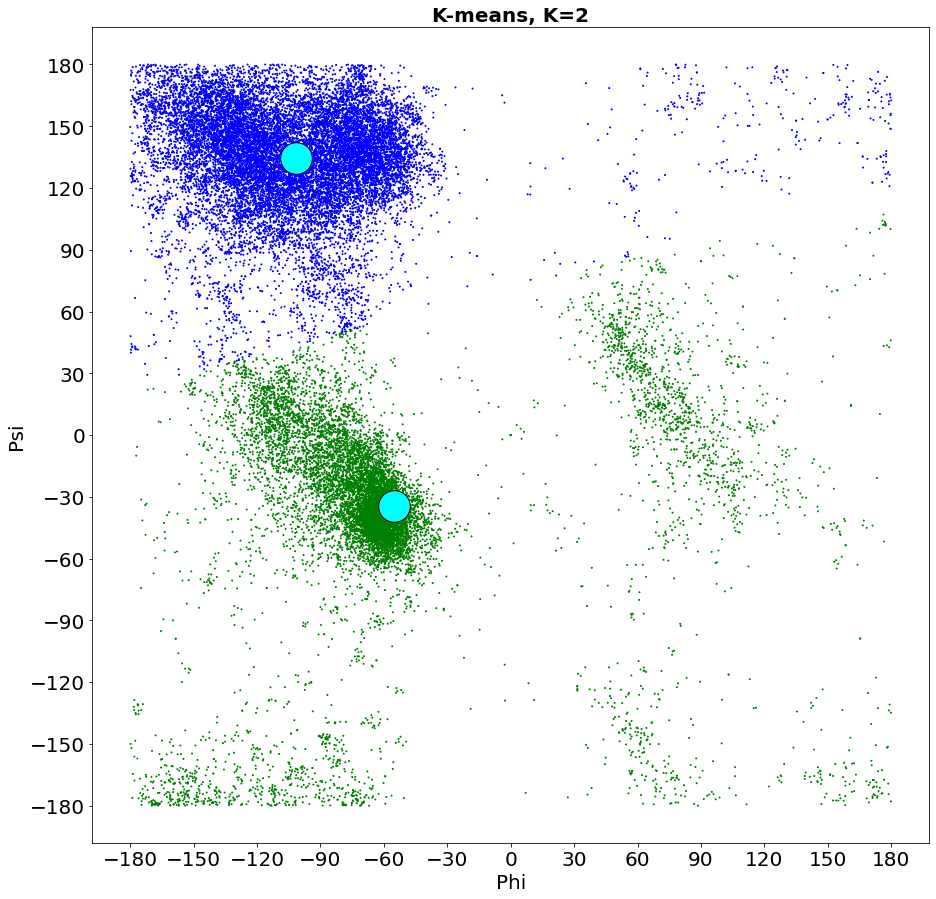

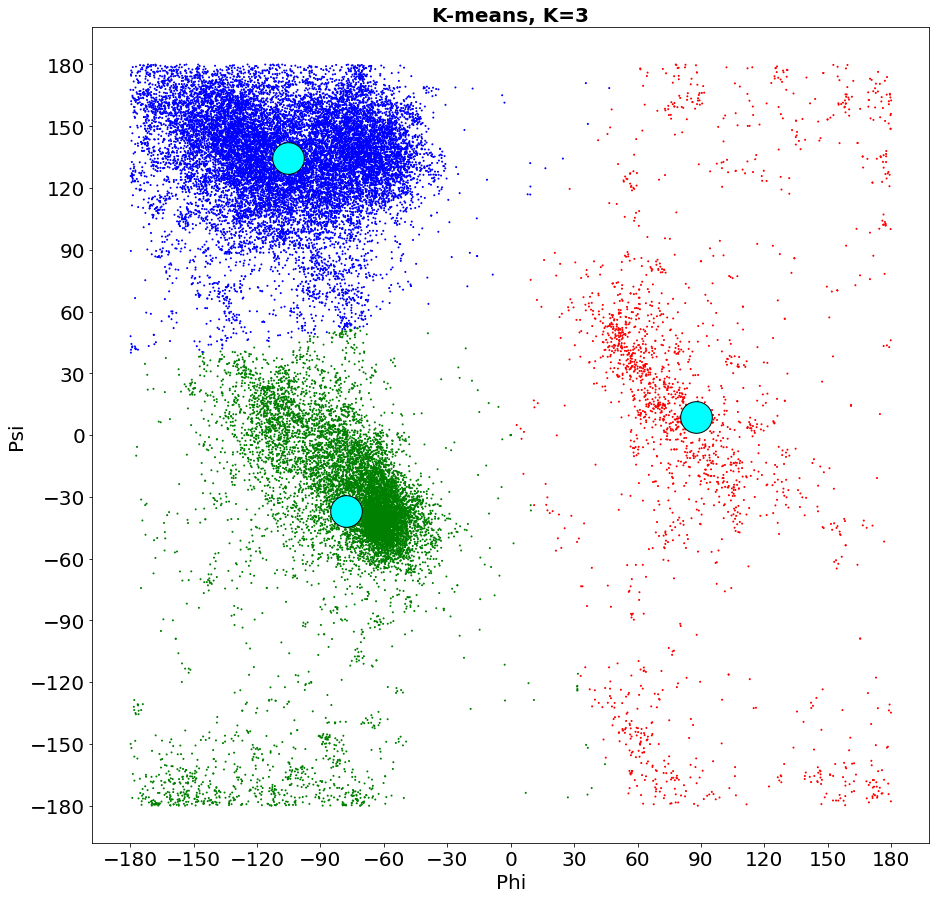

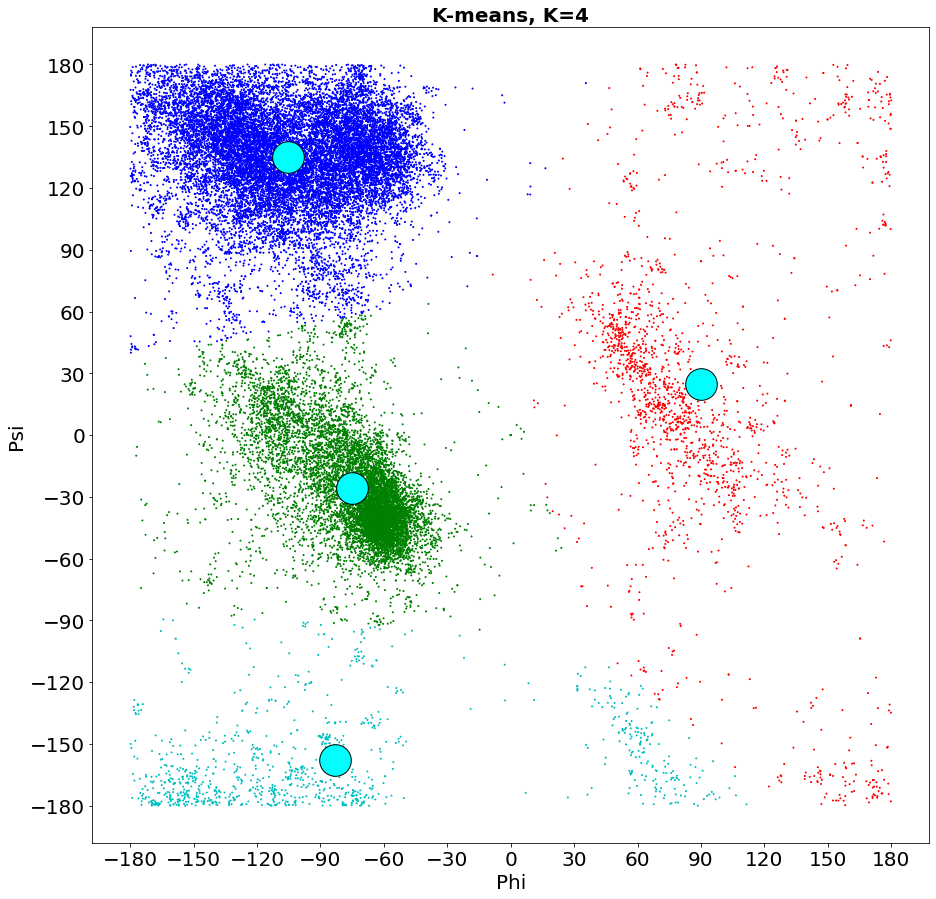

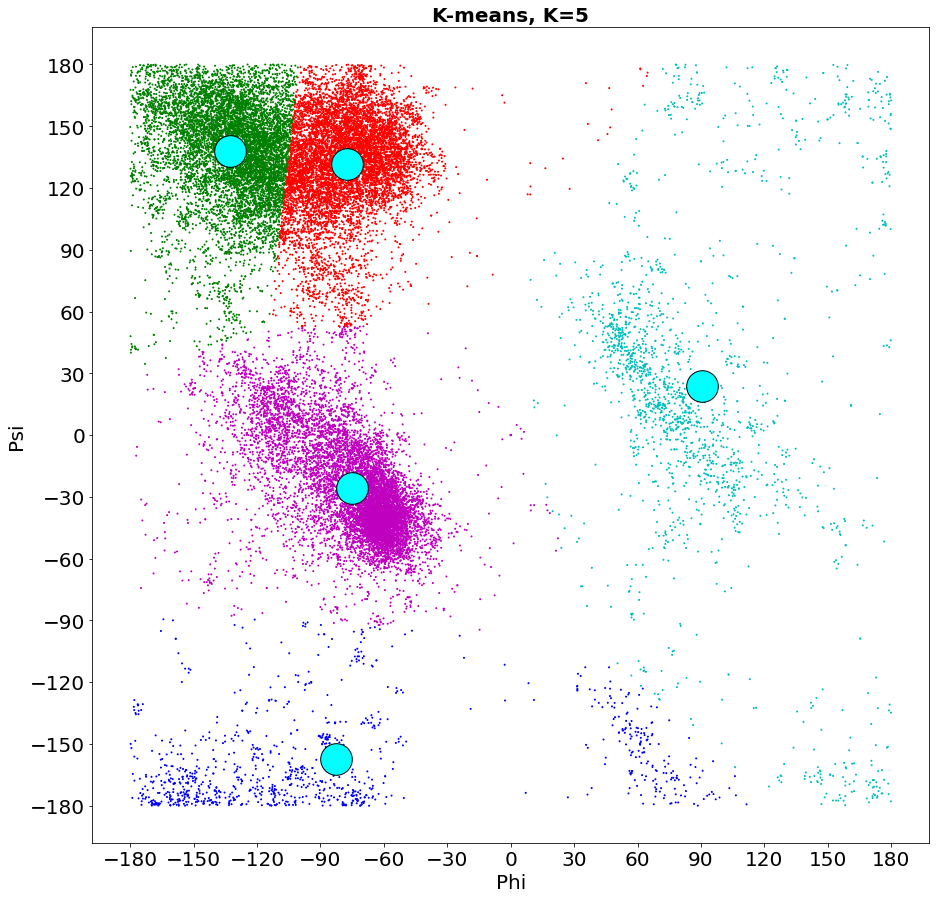

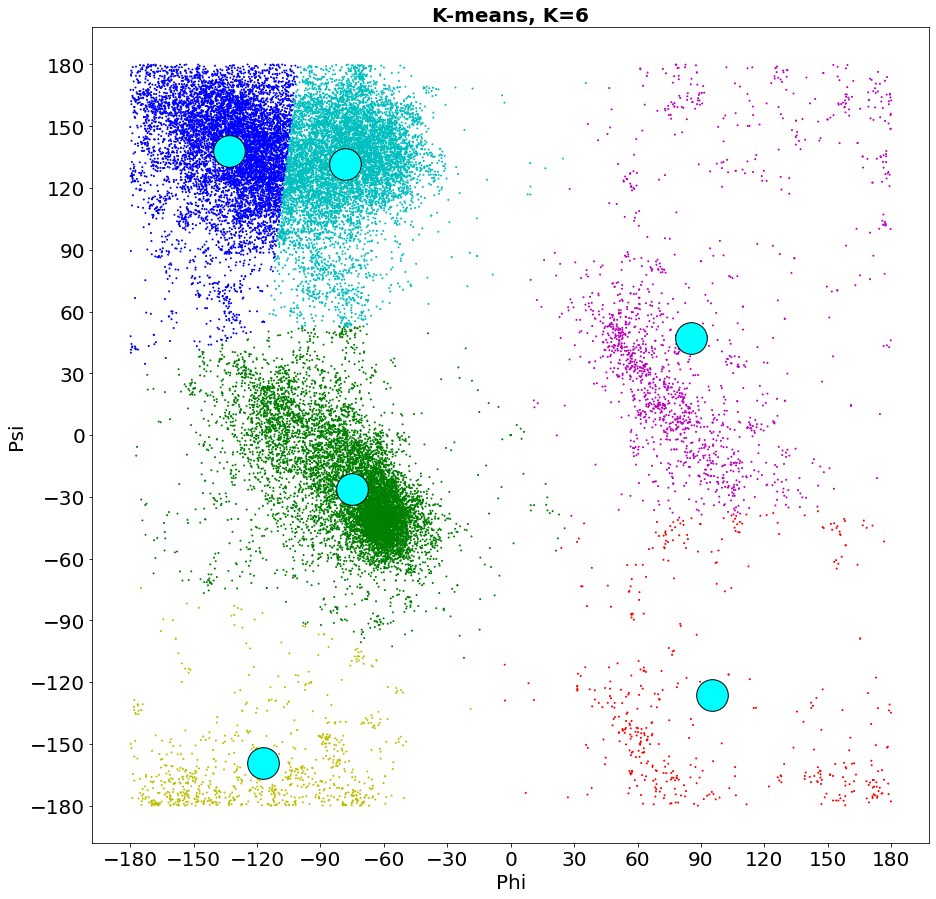

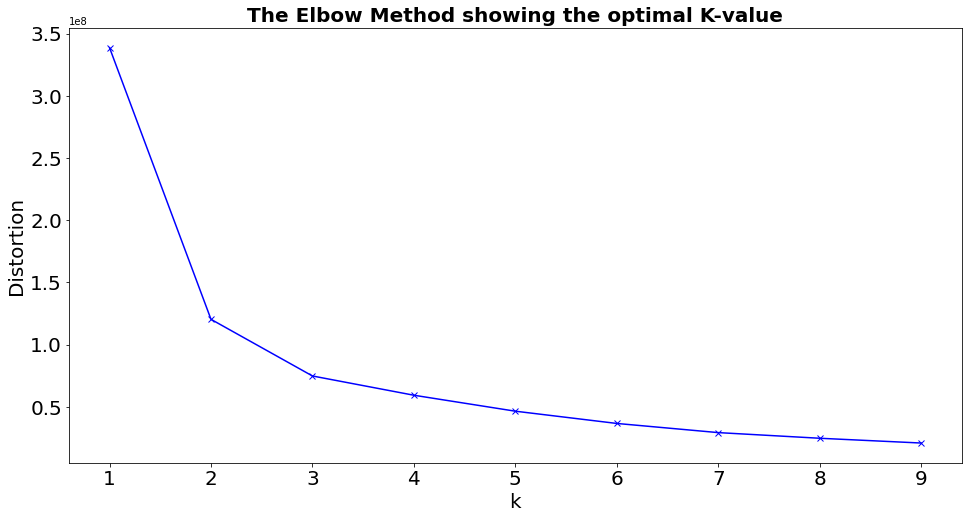

In [4]:
#K-means for different K-values
for i in range(1,7):
    #Model
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)

    #Label colors
    LABEL_COLOR_MAP = {}
    colors = cycle('bgrcmybgrcmybgrcmybgrcmy')
    for k, col in zip(set(kmeans.labels_), colors):
        LABEL_COLOR_MAP[k] = col
    label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

    #Plot
    plt.rcParams["figure.figsize"] = (15,15)
    plt.scatter(x,y, c=label_color, s=1)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='aqua', s=1000, marker='o', edgecolors='black')
    plt.title("K-means, K={}".format(i), fontsize=20, fontweight='bold')
    plt.ylabel("Psi", fontsize=20)
    plt.xlabel("Phi", fontsize=20)
    plt.xticks(np.arange(-180, 210, step=30))
    plt.yticks(np.arange(-180, 210, step=30))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()


#Elbow method
distortions = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('k', fontsize=20)
plt.ylabel('Distortion',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('The Elbow Method showing the optimal K-value',fontsize=20, fontweight='bold')
plt.show()

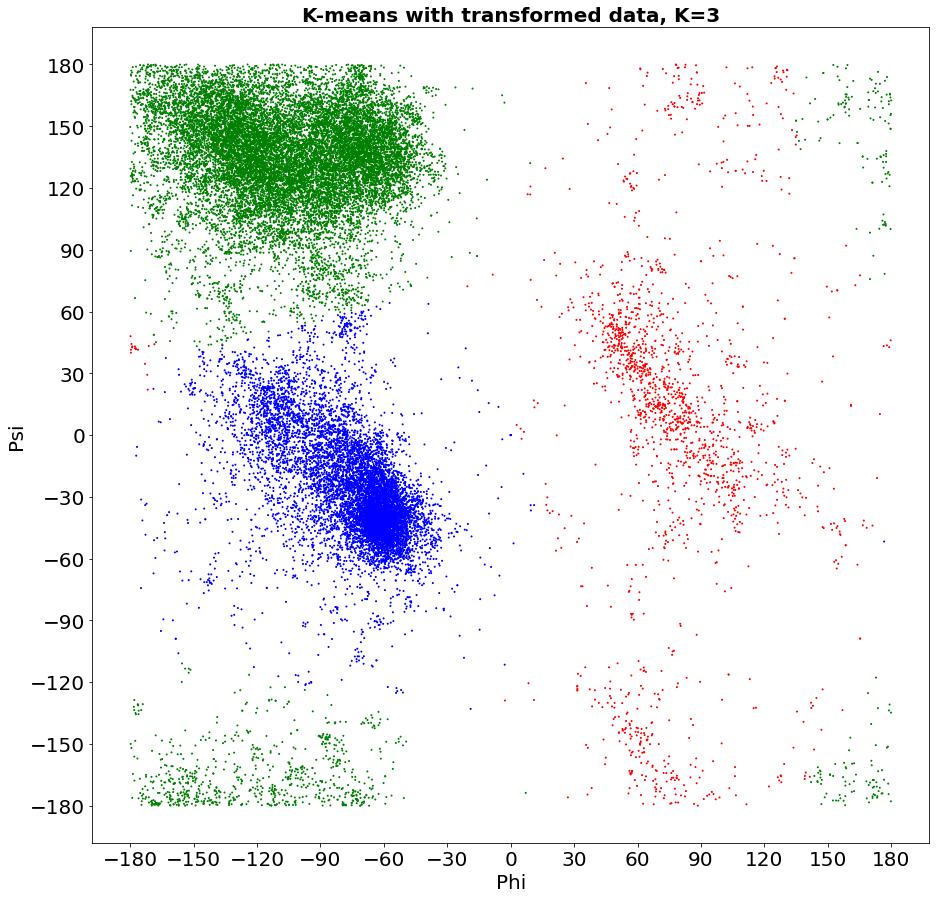

In [5]:
#Transformation of data
x_sin = []
x_cos = []
for i in x:
    x_sin.append(math.sin(math.radians(i)))
    x_cos.append(math.cos(math.radians(i)))

y_sin = []
y_cos = []
for i in y:
    y_sin.append(math.sin(math.radians(i)))
    y_cos.append(math.cos(math.radians(i)))

X_trig = list(zip(x_sin, y_sin, x_cos, y_cos))

#New model
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_trig)

#Label colors
LABEL_COLOR_MAP = {}
colors = cycle('bgrcmybgrcmybgrcmybgrcmy')
for k, col in zip(set(kmeans.labels_), colors):
    LABEL_COLOR_MAP[k] = col

label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

#Plot
plt.rcParams["figure.figsize"] = (15,15)
plt.scatter(x,y, c=label_color, s=1)
plt.title("K-means with transformed data, K=3", fontsize=20, fontweight='bold')
plt.ylabel("Psi", fontsize=20)
plt.xlabel("Phi", fontsize=20)
plt.xticks(np.arange(-180, 210, step=30))
plt.yticks(np.arange(-180, 210, step=30))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

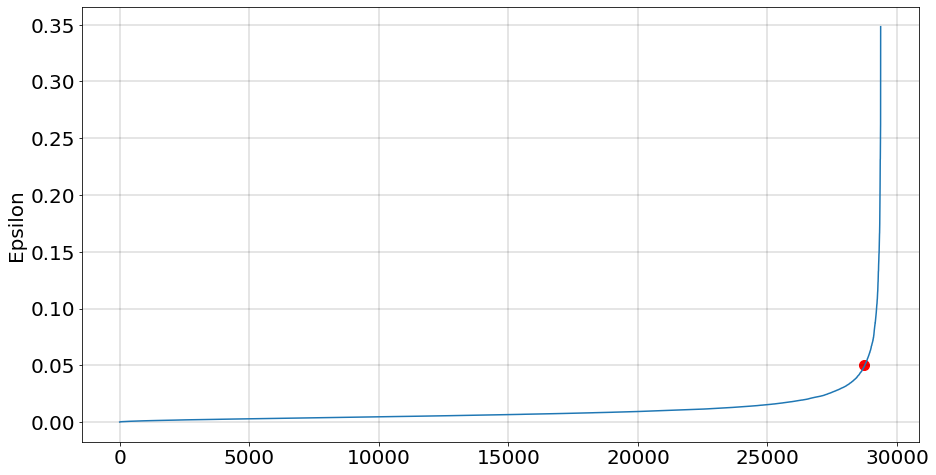

In [6]:
#Epsilon estimation using elbow
neigh = NearestNeighbors(n_neighbors=8)
nbrs = neigh.fit(X_trig)
distances, indices = nbrs.kneighbors(X_trig)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(distances)
plt.grid(color='black', linestyle='-', linewidth=2, alpha=0.1)
plt.ylabel("Epsilon", fontsize=20)
plt.scatter(28725, 0.05, s=100, c='r')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [7]:
#Method to do a DBSCAN and plotting the result
#inputs:
#v = [orgX, transformedX, eps, minpts]
#barchart = boolean for plotting outliers barchart
def do_dbscan(v, barchart):
    db = DBSCAN(eps=v[2], min_samples=v[3]).fit(v[1])
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

    core_samples = db.core_sample_indices_  

    # Plot result
    # Black removed and is used for noise instead.
    plt.rcParams["figure.figsize"] = (15,15)
    colors = cycle('bgrcmybgrcmybgrcmybgrcmy')
    for k, col in zip(set(labels), colors):
        if k == -1:
            # Black used for noise.
            col = 'k'
            markersize = 6
        class_members = [index[0] for index in np.argwhere(labels == k)]
        cluster_core_samples = [index for index in core_samples
                                if labels[index] == k]
        for index in class_members:
            xy = v[0][index]
            if index in core_samples and k != -1:
                markersize = 14
            else:
                markersize = 6
            plt.plot(xy[0], xy[1], 'o', markerfacecolor=col,
                    markeredgecolor='k', markersize=markersize)

    plt.title('DBSCAN, clusters={}, epsilon={}, minpoints={}'.format(n_clusters_, v[2], v[3]), fontsize=20, fontweight='bold')
    plt.ylabel("Psi", fontsize=20)
    plt.xlabel("Phi", fontsize=20)
    plt.xticks(np.arange(-180, 210, step=30))
    plt.yticks(np.arange(-180, 210, step=30))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

    #Plot outliers per amino residue type
    if barchart:
        plt.rcParams["figure.figsize"] = (20,8)
        test = pd.DataFrame(list(zip(d.residuename, labels)), columns =['Name', 'label'])
        test = test[test['label'] == -1].groupby('Name').agg('count')
        test.plot.bar()
        plt.title("Outliers per amino acid residue type", fontsize=20, fontweight='bold')
        plt.ylabel("Number of outliers", fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.show()

Estimated number of clusters: 70
Estimated number of noise points: 2461


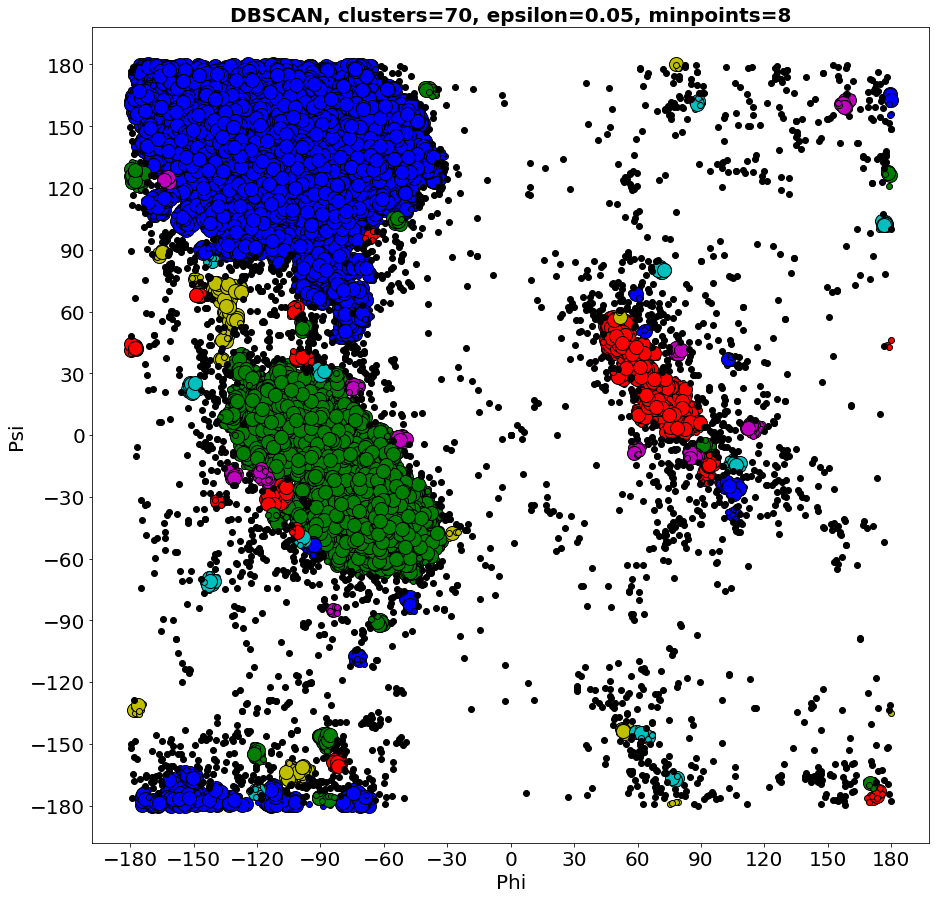

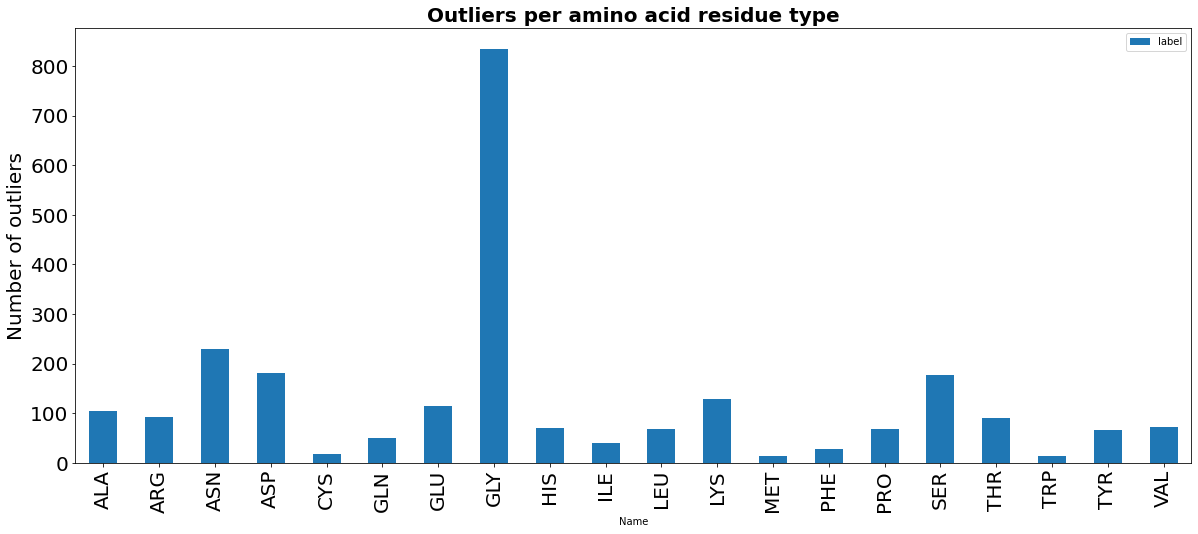

Estimated number of clusters: 6
Estimated number of noise points: 1764


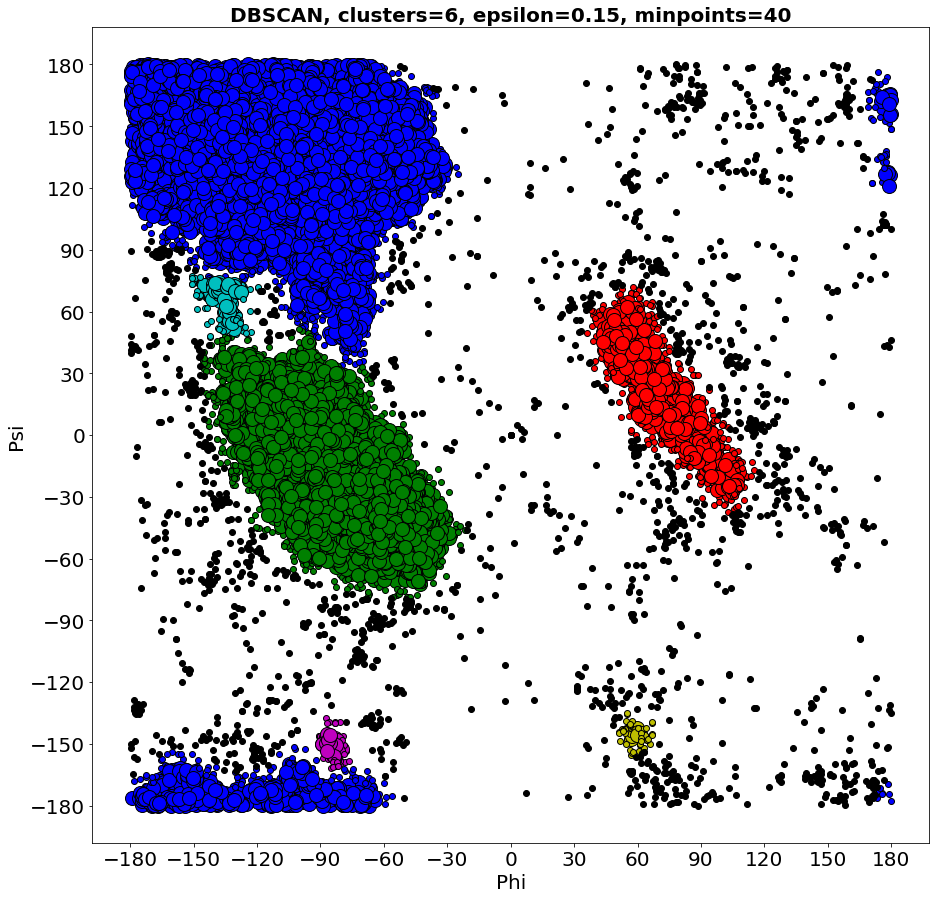

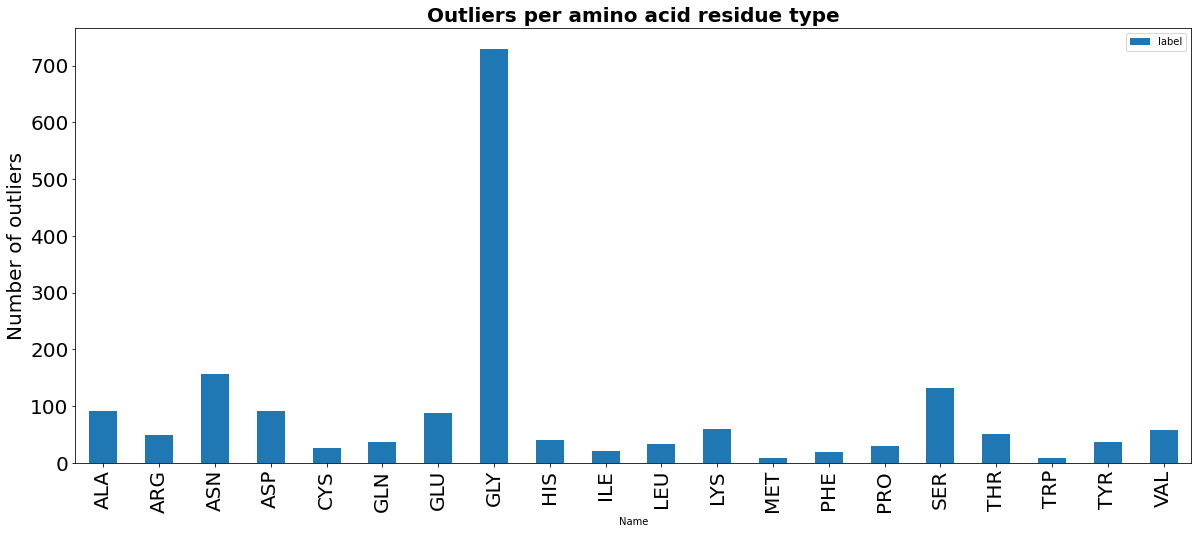

In [8]:
#DBSCAN for different eps and minpts
values = [[X, X_trig, 0.05, 8], [X, X_trig, 0.15, 40]]
for v in values:
    do_dbscan(v, True)

In [9]:
#Filtering out PRO and doing sin/cos transformation
d_pro = d[d['residuename']=='PRO']
x_pro = d_pro.phi
y_pro = d_pro.psi
X_pro = list(zip(x_pro, y_pro))

x_pro_sin = []
x_pro_cos = []
for i in x_pro:
    x_pro_sin.append(math.sin(math.radians(i)))
    x_pro_cos.append(math.cos(math.radians(i)))

y_pro_sin = []
y_pro_cos = []
for i in y_pro:
    y_pro_sin.append(math.sin(math.radians(i)))
    y_pro_cos.append(math.cos(math.radians(i)))

X_pro_trig = list(zip(x_pro_sin, y_pro_sin, x_pro_cos, y_pro_cos))

#Filtering out GLY and doing sin/cos transformation
d_gly = d[d['residuename']=='GLY']
x_gly = d_gly.phi
y_gly = d_gly.psi
X_gly = list(zip(x_gly, y_gly))

x_gly_sin = []
x_gly_cos = []
for i in x_gly:
    x_gly_sin.append(math.sin(math.radians(i)))
    x_gly_cos.append(math.cos(math.radians(i)))

y_gly_sin = []
y_gly_cos = []
for i in y_gly:
    y_gly_sin.append(math.sin(math.radians(i)))
    y_gly_cos.append(math.cos(math.radians(i)))

X_gly_trig = list(zip(x_gly_sin, y_gly_sin, x_gly_cos, y_gly_cos))

Estimated number of clusters: 2
Estimated number of noise points: 186


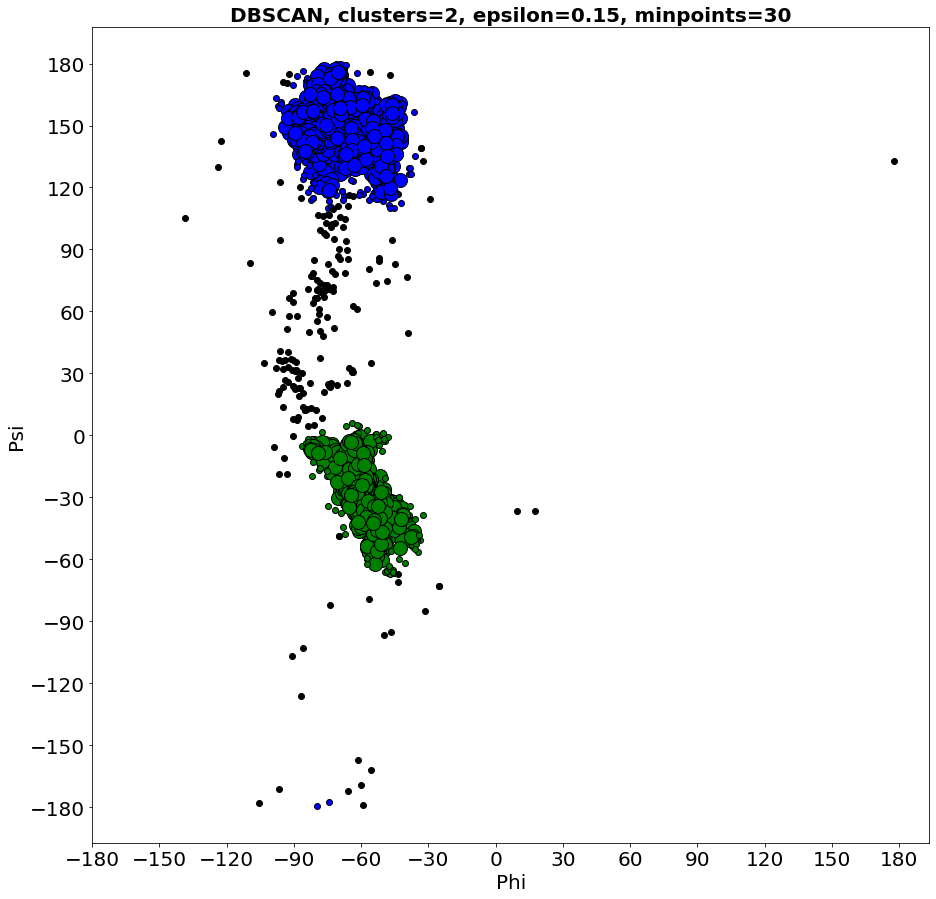

Estimated number of clusters: 7
Estimated number of noise points: 1343


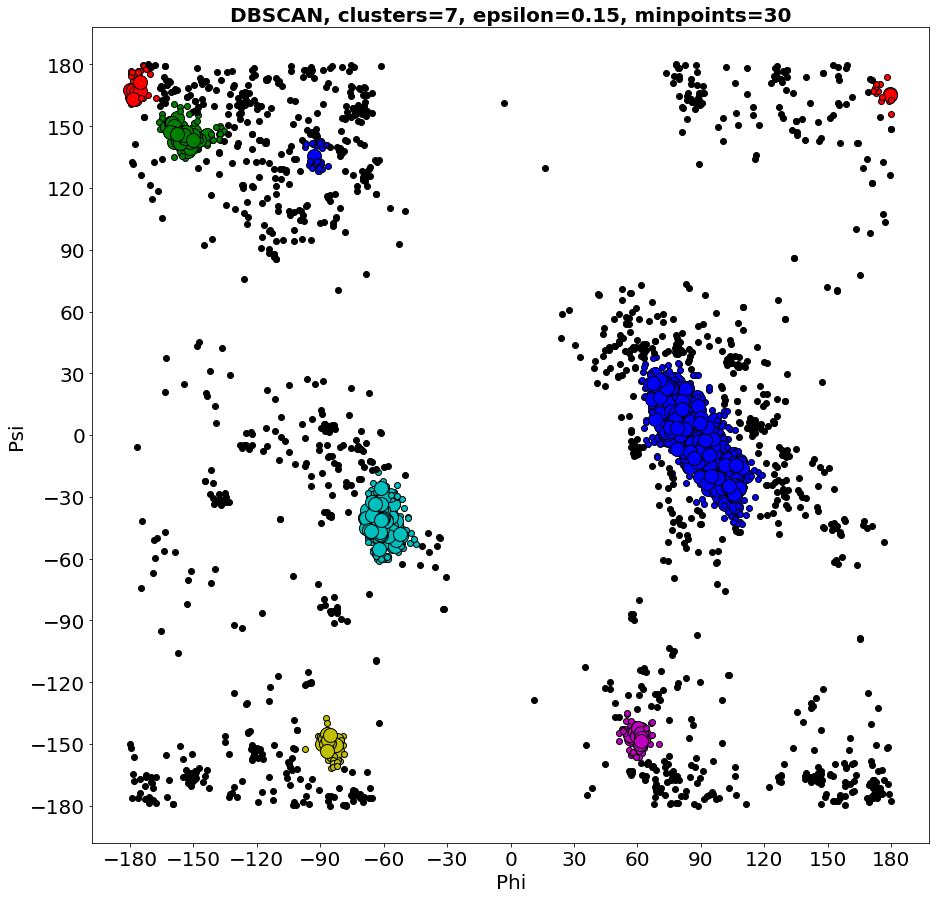

In [10]:
#DBSCAN for residue type PRO and GLY
values = [[X_pro, X_pro_trig, 0.15, 30], [X_gly, X_gly_trig, 0.15, 30]]
for v in values:
    do_dbscan(v, False)